## Trabajo Práctico Machine Learning Experimentación

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

Según lo definido en el TP anterior: 

### Vamos a utilizar las siguientes variables como entradas

* km
* año_fabricacion
* cilindrada
* caballos_fuerza
* tipo_carroceria
* año_control
* transmision
* cantidad_puertas
* cantidad_asientos
* combustible

Ante esto, decidimos descartar las columnas de combustible y año_control ya que ambas tenían más del 50% de valores nulos. 

In [2]:
zf = zipfile.ZipFile('Data/cars_ads.zip')
datos = pd.read_csv(zf.open('cars_ads.csv'), usecols = ['mileage','manufacture_year', 'engine_displacement', 'engine_power', 'body_type', 'transmission', 'door_count', 'seat_count', 'price_eur'])

/home/gabrieltassone/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
NOMBRES_COLUMNAS = {
    'mileage' : 'km',
    'manufacture_year' : 'año_fabricacion',
    'engine_displacement' : 'cilindrada',
    'engine_power' : 'caballos_fuerza',
    'body_type' : 'tipo_carroceria',
    'transmission' : 'transmision',
    'door_count' : 'cantidad_puertas',
    'seat_count' : 'cantidad_asientos',
    'price_eur' : 'precio'
}
datos.rename(columns=NOMBRES_COLUMNAS, inplace=True)

In [4]:
datos.head()

,km,año_fabricacion,cilindrada,caballos_fuerza,tipo_carroceria,transmision,cantidad_puertas,cantidad_asientos,precio
0,151000.0,2011.0,2000.0,103.0,NaN,man,5,7,10584.75
1,143476.0,2012.0,2000.0,81.0,NaN,man,5,5,8882.31
2,97676.0,2010.0,1995.0,85.0,NaN,man,5,5,12065.06
3,111970.0,2004.0,1200.0,47.0,NaN,man,5,5,2960.77
4,128886.0,2004.0,1200.0,47.0,NaN,man,5,5,2738.71


#### Valores nulos

Si bien no es lo que debería hacerse en la realidad, a modo de simplificar el problema y debido a que contábamos con una gran cantidad de registros (3500000 aproximadamente), decidimos eliminar las filas con valores nulos. 

En caso de enfrentarse con algo similar en una situación de trabajo o en una investigación, habría que dar un mejor tratamiento a los registros con valores nulos como ser completarlos con valores promedios, solicitar o buscar más datos para poder completarlos, o aplicar otras técnicas para no tener que desechar gran cantidad de datos que podrían ser útiles.

In [5]:
datos = datos.dropna()

In [6]:
datos.dtypes

km                   float64
año_fabricacion      float64
cilindrada           float64
caballos_fuerza      float64
tipo_carroceria       object
transmision           object
cantidad_puertas      object
cantidad_asientos     object
precio               float64
dtype: object

In [7]:
print('Cantidad de nulos de cada variable')
print(' ')
print('km - ' + str(datos.km.isnull().sum()))
print('año_fabricacion - ' + str(datos.año_fabricacion.isnull().sum()))
print('cilindrada - ' + str(datos.cilindrada.isnull().sum()))
print('caballos_fuerza - ' + str(datos.caballos_fuerza.isnull().sum()))
print('tipo_carroceria - ' + str(datos.tipo_carroceria.isnull().sum()))
print('transmision - ' + str(datos.transmision.isnull().sum()))
print('cantidad_puertas - ' + str(datos.cantidad_puertas.isnull().sum()))
print('cantidad_asientos - ' + str(datos.cantidad_asientos.isnull().sum()))

Cantidad de nulos de cada variable
 
km - 0
año_fabricacion - 0
cilindrada - 0
caballos_fuerza - 0
tipo_carroceria - 0
transmision - 0
cantidad_puertas - 0
cantidad_asientos - 0


### Pre-procesado de los datos

Ante esta cantidad de datos nulos y los distintos tipos de datos que tendríamos como entradas, nos vemos obligados a hacer ciertos cambios en el dataset para que sirvan como entradas a los distintos modelos que vamos a entrenar. 

In [8]:
conditions = [
    (datos['precio'] < 4000),
    (datos['precio'] >= 4000) & (datos['precio'] <= 10000),
    (datos['precio'] > 10000)]
choices = ['A', 'B', 'C']
datos['categoria_auto'] = np.select(conditions, choices)

conditions = [
    (datos['precio'] < 4000),
    (datos['precio'] >= 4000) & (datos['precio'] <= 10000),
    (datos['precio'] > 10000)]
choices = [0,1,2]
datos['categoria_auto_numerica'] = np.select(conditions, choices)

In [9]:
datos.shape

(1179100, 11)

#### Variable transmision

Transformamos la variable transmision de manual o automática a 0 o 1, ya que muchos de los modelos que vamos a utilizar sólo aceptan valores numéricos como entradas.

In [10]:
conditions = [
    (datos['transmision'] == 'man'),
    (datos['transmision'] == 'auto')]
choices = [0, 1]
datos['transmision'] = np.select(conditions, choices)

#### Variable tipo_carroceria 

Reemplazamos la variable tipo carrocería por números del 1 al 9, asignando uno a cada tipo de carrocería posible.

In [11]:
conditions = [
    (datos['tipo_carroceria'] == 'van'),(datos['tipo_carroceria'] == 'compact'),
    (datos['tipo_carroceria'] == 'transporter'),(datos['tipo_carroceria'] == 'coupe'),
    (datos['tipo_carroceria'] == 'convertible'),(datos['tipo_carroceria'] == 'sedan'),
    (datos['tipo_carroceria'] == 'stationwagon'),(datos['tipo_carroceria'] == 'offroad'),
    (datos['tipo_carroceria'] == 'other')]
choices = [1, 2, 3, 4, 5, 6, 7, 8, 9]
datos['tipo_carroceria'] = np.select(conditions, choices)

#### Variable año_fabricacion

Determinamos que el año mínimo de fabricación de los autos va a ser 1970, esto lo hacemos a modo de eliminar outliers de datos posiblemente mal cargados. 

In [12]:
datos.loc[datos.año_fabricacion < 1970.0, 'año_fabricacion'] = 1970.0

#### Variable cilindrada

Decidimos que la cilindrada máxima de los autos va a ser de 5000.0 (que si bien es alto, habia datos que sobrepasaban esa cilindrada y no es algo que se vea en el día a día), por lo que los autos que hayan cargado más que esa cantidad se le va a asignar 5000. 

In [13]:
datos.loc[datos.cilindrada > 5000.0, 'cilindrada'] = 5000.0

#### Variable cantidad_puertas

Modificamos esta columna a tipo de dato numerico o float ya que, por ejemplo, había autos cargados con 5 puertas y autos cargados con 5.0 puertas lo que se tomaba como dos cantidades diferentes cuando eran la misma.

In [14]:
datos.cantidad_puertas = pd.to_numeric(datos.cantidad_puertas, errors='coerce')

#### Variable cantidad_asientos 

Mismo caso que el anterior. No trabajamos con el tema de outliers ya que había algunos registros con entre 30 y 50 asientos, y desconocemos si dentro de la categoría de auto transporter o en alguna otra puede haber vehículos de estilo trafic o colectivos que puedan tener esa cantidad de asientos. 

In [15]:
datos.cantidad_asientos = pd.to_numeric(datos.cantidad_asientos, errors='coerce')

In [16]:
datos = datos.dropna()

#### Variable km

Para la variable km aplicamos la técnica de feature engineering de redondeo ya que consideramos que una diferencia menor a 100 o 1000 KM no debería influir demasiado en el precio del auto, e incluso podría ayudar a sobreentrenar el modelo, por lo que también sería una técnica útil para prevenir el sobreentrenamiento.

In [17]:
datos.km = (datos.km / 1000).astype(int) * 1000

In [18]:
datos = datos.drop_duplicates()

In [19]:
datos.shape

(963080, 11)

In [20]:
datos.head()

,km,año_fabricacion,cilindrada,caballos_fuerza,tipo_carroceria,transmision,cantidad_puertas,cantidad_asientos,precio,categoria_auto,categoria_auto_numerica
507,203000,2011.0,2143.0,120.0,1,0,5.0,5.0,22168.76,C,2
577,245000,2007.0,2461.0,96.0,1,0,5.0,9.0,8475.20,B,1
583,248000,2005.0,2461.0,128.0,1,0,5.0,8.0,9215.40,B,1
898,137000,2011.0,2000.0,103.0,1,0,5.0,5.0,9437.45,B,1
1007,182000,2002.0,1795.0,90.0,1,0,5.0,5.0,1073.28,A,0


In [21]:
datos.dtypes

km                           int64
año_fabricacion            float64
cilindrada                 float64
caballos_fuerza            float64
tipo_carroceria              int64
transmision                  int64
cantidad_puertas           float64
cantidad_asientos          float64
precio                     float64
categoria_auto              object
categoria_auto_numerica      int64
dtype: object

In [22]:
print('Cantidad de nulos de cada variable')
print(' ')
print('km - ' + str(datos.km.isnull().sum()))
print('año_fabricacion - ' + str(datos.año_fabricacion.isnull().sum()))
print('cilindrada - ' + str(datos.cilindrada.isnull().sum()))
print('caballos_fuerza - ' + str(datos.caballos_fuerza.isnull().sum()))
print('tipo_carroceria - ' + str(datos.tipo_carroceria.isnull().sum()))
print('transmision - ' + str(datos.transmision.isnull().sum()))
print('cantidad_puertas - ' + str(datos.cantidad_puertas.isnull().sum()))
print('cantidad_asientos - ' + str(datos.cantidad_asientos.isnull().sum()))

Cantidad de nulos de cada variable
 
km - 0
año_fabricacion - 0
cilindrada - 0
caballos_fuerza - 0
tipo_carroceria - 0
transmision - 0
cantidad_puertas - 0
cantidad_asientos - 0


Separamos el dataset en train, test y validation

In [23]:
train, not_train = train_test_split(datos, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.5)

In [24]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function, include_validation=False):
    sets = [('train', train), ('test', test), ('validation', validation)]
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs)
        
        print(set_name, '#' * 80)
        
        # print metrics
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        print('precision_score', precision_score(outputs, predictions, average="macro"))
        print('recall', recall_score(outputs, predictions, average="macro"))
        print()
        
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1, 2], ['A', 'B', 'C'], rotation=45)
        plt.yticks([0, 1, 2], ['A', 'B', 'C'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions), 
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

### Definición de la métrica

La métrica que vamos a utilizar va a ser "accuracy", esto nos va a permitir determinar en qué porcentaje acertó a la hora de predecir. 

Esta métrica suele ser útil en los problemas de clasificación, y dado que el nuestro es un problema de clasificación pensamos que es buena idea utilizarla como referencia. 

Otro motivo podría ser que, para nuestro caso, errar por SI o por NO no tiene diferente impacto, por lo que no tenemos necesidad de recurrir a otra métrica como recall o precission. 

### Primer modelo: Regresión Logística

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [26]:
# final input columns, in the order we want to use them
LR_INPUT_COLUMNS = [
    'km','año_fabricacion', 'cilindrada', 'caballos_fuerza', 
    'tipo_carroceria', 'transmision', 'cantidad_puertas', 'cantidad_asientos',
]


def lr_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy() 
    
    # return the raw numbers
    return inputs[LR_INPUT_COLUMNS].values.astype(np.float64)

def lr_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.categoria_auto_numerica.values


In [27]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
])

In [28]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
)

/usr/local/lib/python3.5/dist-packages/scipy/optimize/linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])

train ################################################################################
Accuracy: 0.760750231895
precision_score 0.738488043019
recall 0.720989798557



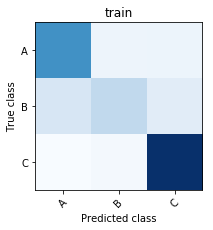

test ################################################################################
Accuracy: 0.758747975246
precision_score 0.736826100167
recall 0.719533727787



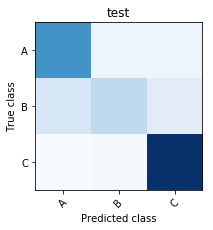

validation ################################################################################
Accuracy: 0.759614985256
precision_score 0.737245968885
recall 0.720461278183



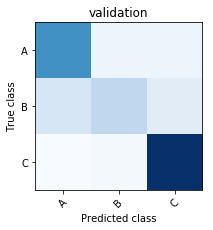

In [29]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs)

#### Conclusiones

Es un modelo muy rápido para poder tener una primer aproximación.

El modelo predice con una accuracy de 0.7587 en testing y 0.7596 en validation. Para ser un modelo sencillo y muy rápido de ejecutar es un resultado bueno. 

### Segundo modelo: Árboles de decisión

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
# final input columns, in the order we want to use them
TREE_INPUT_COLUMNS = [
    'km','año_fabricacion', 'cilindrada', 'caballos_fuerza', 
    'tipo_carroceria', 'transmision', 'cantidad_puertas', 'cantidad_asientos',
]


def tree_extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
   
    # return the raw numbers
    return inputs[TREE_INPUT_COLUMNS].values

def tree_extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.categoria_auto.values

In [32]:
tree_model = DecisionTreeClassifier()
# max_depth=3?

In [33]:
tree_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

train ################################################################################
Accuracy: 0.970360717697
precision_score 0.968105010012
recall 0.96817753176



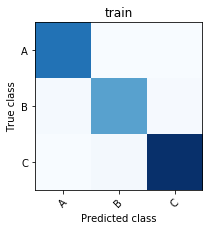

test ################################################################################
Accuracy: 0.814719441791
precision_score 0.797082105313
recall 0.797236199649



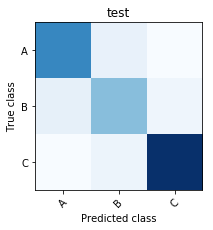

validation ################################################################################
Accuracy: 0.815742202102
precision_score 0.798357295178
recall 0.798734824534



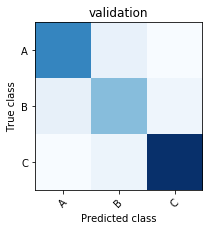

In [34]:
evaluate_model(tree_model, tree_extract_inputs, tree_extract_outputs)

#### Conclusiones

El modelo tiene una accuracy de 0,8147 en test y 0,8157 en validation. 

La métrica mejoró un poco si lo comparamos con el modelo anterior.

Tiene problemas principalmente con los autos de tipo B, suele clasificar como A o C algunos autos que son de tipo B, y algunos autos de tipo A y C los clasifica como B. 

No se observa que cuando el auto es de tipo A arroje como predicción C, tampoco se observa que cuando el auto es de tipo C arroje A. Estos dos grupos los puede diferenciar bastante bien. 


### Tercer modelo: Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
forest_model = RandomForestClassifier(n_estimators = 15, max_features=6)
# n_estimators? max_depth=3?, max_features=2?

In [37]:
forest_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

train ################################################################################
Accuracy: 0.965859533995
precision_score 0.964198437373
recall 0.962158135178



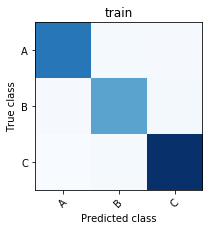

test ################################################################################
Accuracy: 0.840978942559
precision_score 0.826015836195
recall 0.824071296563



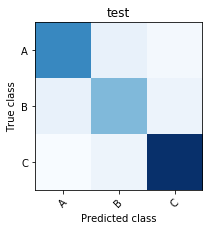

validation ################################################################################
Accuracy: 0.842188603231
precision_score 0.827334306559
recall 0.825771738082



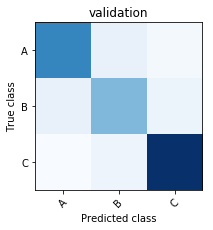

In [38]:
evaluate_model(forest_model, tree_extract_inputs, tree_extract_outputs)

#### Conclusiones 

Este modelo llega a obtener una accuracy de 0,8410 en test y 0,8422 en validation. 

Esto puede deberse a que Random Forest implica una mejora ante los tradicionales árboles de decisión, ya que posee un mayor número de estimadores base, se puede definir la cantidad de variables a utilizar en cada split, y también se le puede definir los mismos parámetros que a los árboles.

Posee el mismo problema que los modelos anteriores en cuanto a los autos de categoria B.

### Cuarto modelo: Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
boost_model = GradientBoostingClassifier()

In [41]:
boost_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

train ################################################################################
Accuracy: 0.838038722986
precision_score 0.824298092307
recall 0.820874366664



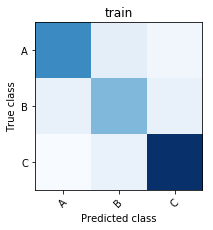

test ################################################################################
Accuracy: 0.836685425925
precision_score 0.823178045387
recall 0.819522002369



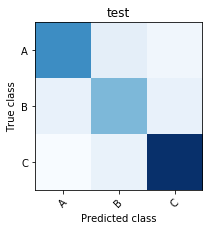

validation ################################################################################
Accuracy: 0.837194210242
precision_score 0.823757366085
recall 0.820393614846



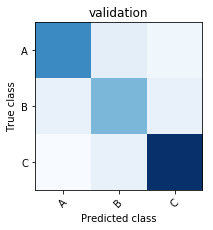

In [42]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs)

#### Conclusiones

La duración al ejecutar este modelo es notablemente mayor a los demás.

Este algoritmo arroja una accuracy de 0,8367 en test y 0,8372 en validation, valores similares a los obtenidos en el modelo anterior. 

Esto puede deberse a que el modelo utiliza árboles como estimadores base, y la idea es ir ajustando estos estimadores base utilizando los errores del modelo previo como variable a predecir. 

No definimos parámetros como n_estimators ni max_depth ya que el entrenamiento del modelo se hacia demasiado largo.

### Valor final de la métrica

Si comparamos los diferentes modelos, Random Forest es el que mayor accuracy obtiene con un 84% aproximadamente tanto en test como en validation, y otra ventaja que tiene es que su tiempo de ejecución o entrenamiento no es tan alto comparado con el modelo de Gradient Boosting. Por estos motivos vamos a elegir a Random Forest como el modelo a utilizar para este problema.

Para determinar el valor final que deberíamos "prometerle" a un posible cliente vamos a realizar varias iteraciones entrenando y prediciendo el modelo, para poder obtener un promedio de las distintas accuracy que obtuvo. 

In [43]:
accuracy_total_test = 0
accuracy_total_validation = 0

for i in range(10):
    
    """Generamos nuevamente los set de datos. 
    No hacemos nuevamente el read_csv ya que deberíamos ejecutar todo el pre-procesado nuevamente."""
    train, not_train = train_test_split(datos, test_size=0.4)
    validation, test = train_test_split(not_train, test_size=0.5)
    
    forest_model = RandomForestClassifier(n_estimators = 15, max_features=6)
    
    forest_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
    )
    
    inputs = tree_extract_inputs(test)
    outputs = tree_extract_outputs(test)
    predictions = forest_model.predict(inputs)
    
    accuracy_total_test += accuracy_score(outputs, predictions)
    
    inputs = tree_extract_inputs(validation)
    outputs = tree_extract_outputs(validation)
    predictions = forest_model.predict(inputs)
        
    accuracy_total_validation += accuracy_score(outputs, predictions)
    
print('La accuracy promedio al realizar 10 iteraciones en test es de: ' + str(accuracy_total_test/10))
print('La accuracy promedio al realizar 10 iteraciones en validation es de: ' + str(accuracy_total_validation/10))

    
    
    
    
    
    

La accuracy promedio al realizar 10 iteraciones en test es de: 0.841783133281
La accuracy promedio al realizar 10 iteraciones en validation es de: 0.841976782822


La métrica concuerda con lo que obtuvimos al realizar la primer iteración, cuando presentamos el modelo, por lo que es un valor bastante estable.

Con este procedimiento podemos decir que el valor final de accuracy es de 0,84 o 84%. 

Como conclusión final del TP podemos decir que, tal como se dijo varias veces en clases, lo más complejo fue realizar el pre-procesado de los datos, debido a que teníamos que tomar distintas decisiones con los datos que, por falta de tiempos y experiencia, pueden no haber sido las mejores. El dataset que elegimos no estaba del todo limpio o balanceado como lo que veníamos trabajando, sin embargo podemos decir que logramos obtener resultados regulares o relativamente buenos. 